In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

healthy_dirs = [
    r'/content/drive/MyDrive/chest_xray/test/NORMAL',
    r'/content/drive/MyDrive/chest_xray/train/NORMAL',
    r'/content/drive/MyDrive/chest_xray/val/NORMAL',
]

pneumonia_dir = [
    r'/content/drive/MyDrive/chest_xray/test/PNEUMONIA',
    r'/content/drive/MyDrive/chest_xray/train/PNEUMONIA',
    r'/content/drive/MyDrive/chest_xray/val/PNEUMONIA'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())


                                           filepaths  labels
0  /content/drive/MyDrive/chest_xray/test/NORMAL/...  Normal
1  /content/drive/MyDrive/chest_xray/test/NORMAL/...  Normal
2  /content/drive/MyDrive/chest_xray/test/NORMAL/...  Normal
3  /content/drive/MyDrive/chest_xray/test/NORMAL/...  Normal
4  /content/drive/MyDrive/chest_xray/test/NORMAL/...  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [ ]:
pneumonia_df.shape

(5856, 2)

In [ ]:
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(4684, 2)
(1757, 2)
(1172, 2)
(4099, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 4684 validated image filenames belonging to 2 classes.
Found 1757 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Normal', 'Pneumonia']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

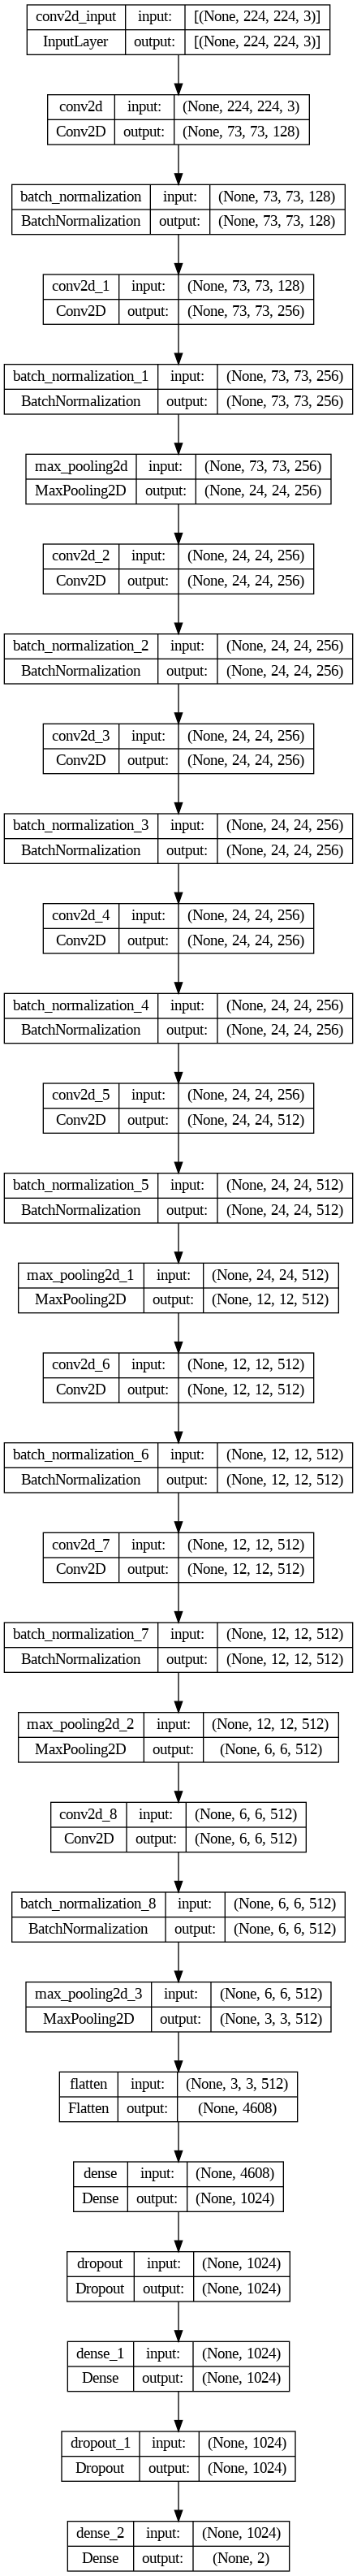

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
1171/1171 [==============================] - 1502s 1s/step - loss: 0.4718 - accuracy: 0.8580 - val_loss: 0.1708 - val_accuracy: 0.9326
Epoch 2/10
1171/1171 [==============================] - 87s 74ms/step - loss: 0.1934 - accuracy: 0.9281 - val_loss: 0.1573 - val_accuracy: 0.9369
Epoch 3/10
1171/1171 [==============================] - 87s 74ms/step - loss: 0.1616 - accuracy: 0.9430 - val_loss: 0.1452 - val_accuracy: 0.9428
Epoch 4/10
1171/1171 [==============================] - 88s 75ms/step - loss: 0.1314 - accuracy: 0.9505 - val_loss: 0.1593 - val_accuracy: 0.9411
Epoch 5/10
1171/1171 [==============================] - 87s 74ms/step - loss: 0.1008 - accuracy: 0.9635 - val_loss: 0.1402 - val_accuracy: 0.9488
Epoch 6/10
1171/1171 [==============================] - 87s 74ms/step - loss: 0.0780 - accuracy: 0.9714 - val_loss: 0.1360 - val_accuracy: 0.9548
Epoch 7/10
1171/1171 [==============================] - 87s 75ms/step - loss: 0.0611 - accuracy: 0.9782 - val_loss: 0.1358 -

In [ ]:
model.evaluate(test, verbose=1)

440/440 [==============================] - 23s 53ms/step - loss: 0.1127 - accuracy: 0.9676


[0.11273225396871567, 0.9675583243370056]

In [ ]:
model.save("pneumonia_Model.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

440/440 [==============================] - 23s 52ms/step


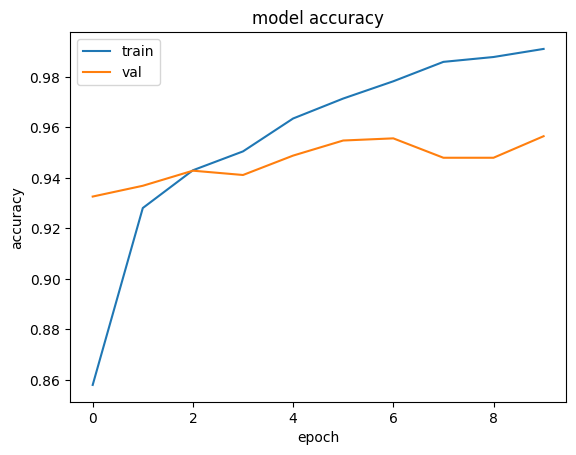

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

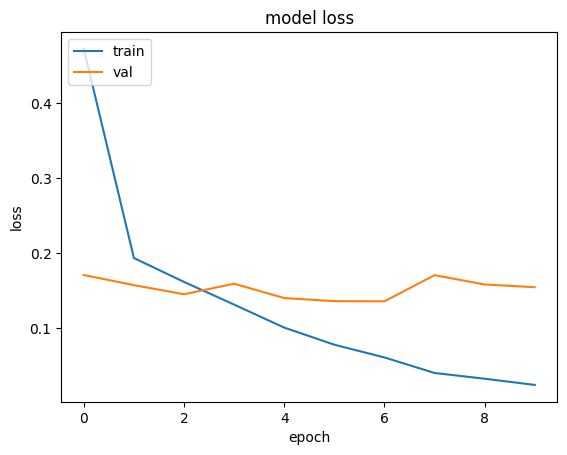

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       505
   Pneumonia       0.97      0.98      0.98      1252

    accuracy                           0.97      1757
   macro avg       0.96      0.96      0.96      1757
weighted avg       0.97      0.97      0.97      1757

Accuracy of the Model: 96.8%


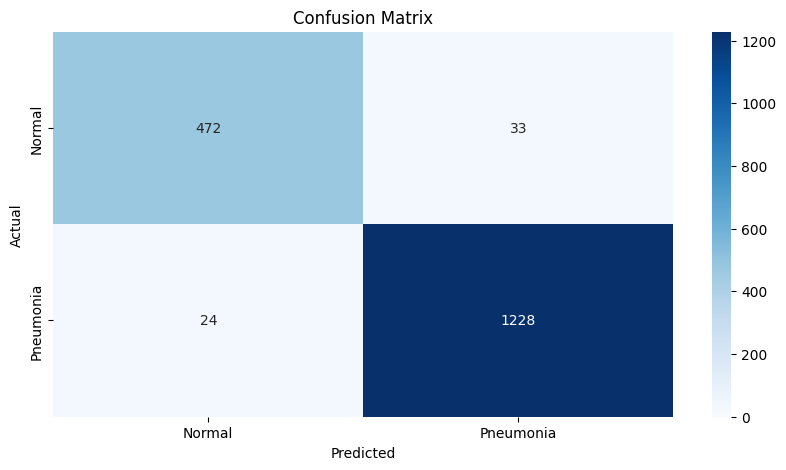

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image

# Load the trained model
model_path = 'pneumonia_Model.h5'
model = load_model(model_path)

# Load the image
img_path = 'image.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_display = cv2.imread(img_path)  # Load image for display purposes

# Preprocess the image
preprocessed_img = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

# Use the trained model to predict
prediction = model.predict(preprocessed_img)

# Interpret the prediction
predicted_class_index = np.argmax(prediction)
if predicted_class_index == 0:
    predicted_class = 'Normal'
else:
    predicted_class = 'Pneumonia'


print("Predicted class: " + predicted_class)



OSError: No file or directory found at pneumonia_Model.h5